<a href="https://colab.research.google.com/github/luigiselmi/dl_tensorflow/blob/main/rooftops_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Rooftops classification
We implement an algorithm for the classification of the rooftops.   

In [20]:
import os
from pathlib import Path
import shutil
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import keras
from keras import layers
from skimage import io
from skimage import exposure
from skimage.io import imsave, imread
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import time
import warnings
warnings.filterwarnings('ignore')
print("NumPy version: %s"%np.__version__)
print('Tensorflow version: {:s}'.format(tf.__version__))
print('Keras version. {}'.format(keras.__version__))

NumPy version: 1.26.4
Tensorflow version: 2.17.1
Keras version. 3.5.0


In [22]:
!pip install keras-tuner --upgrade -q

In [25]:
import keras_tuner as kt

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Rooftop type dataset
We upload the dataset containing 14400 PNG images divided into three rooftop types: flat, hip, gable. The dataset is divided into a train, validation, and test subfolders each contaiining three subfolders each with the images of one of the rooftop types. The dataset is uploaded as a zip file.

In [4]:
from google.colab import files
#files.upload()

## Data organization for Tensorflow
Tensorflow provides the _image_dataset_from_directory()_ utility function to load the data into datasets and batches. We split the data into a train, validation, and test set folders. In each of these folders we will have subfolders, one for each category used for classification. The name of these subfolders is used as the label for the images stored in them.  

* keras_dir   
    * train
        * flat
        * gable
        * hip
    * validation  
        * flat
        * gable
        * hip
    * test
        * flat
        * gable
        * hip

In [5]:
import zipfile
from zipfile import ZipFile
DATADIR = '.'

In [6]:
ls -al

total 834436
drwxr-xr-x 1 root root      4096 Dec  6 14:44 ./
drwxr-xr-x 1 root root      4096 Dec  6 14:19 ../
-rw-r--r-- 1 root root 854440383 Dec  6 14:50 alidoost_png_dataset.zip
drwxr-xr-x 4 root root      4096 Dec  4 14:23 .config/
drwxr-xr-x 1 root root      4096 Dec  4 14:23 sample_data/


In [7]:
with ZipFile(f'{DATADIR}/alidoost_png_dataset.zip', 'r') as zipObj:
   zipObj.extractall(path=f'{DATADIR}')

In [9]:
dataset_dir_path = Path('png_dataset/train') # original images
rooftop_types = [os.path.basename(sub_folder) for sub_folder in dataset_dir_path.iterdir() if sub_folder.is_dir()]
rooftop_types

['flat', 'gable', 'hip']

In [10]:
png_dir = 'png_dataset/'
png_dir_path = Path(png_dir)
png_dir_path

PosixPath('png_dataset')

In [12]:
from tensorflow.keras.utils import image_dataset_from_directory

batch_size = 32

train_dataset = image_dataset_from_directory(png_dir_path / 'train',
                                             labels='inferred',
                                             label_mode='int',
                                             image_size=(image_height, image_width),
                                             batch_size=batch_size)

validation_dataset = image_dataset_from_directory(png_dir_path / 'validation',
                                                  labels='inferred',
                                                  label_mode='int',
                                                  image_size=(image_height, image_width),
                                                  batch_size=batch_size)

test_dataset = image_dataset_from_directory(png_dir_path / 'test',
                                            labels='inferred',
                                            label_mode='int',
                                            image_size=(image_height, image_width),
                                            batch_size=batch_size)

Found 9000 files belonging to 3 classes.
Found 3000 files belonging to 3 classes.
Found 2400 files belonging to 3 classes.


In [13]:
label_batch_list = []
for data_batch, labels_batch in test_dataset:
    label_batch_list.append(labels_batch.numpy())

test_labels = np.concatenate(label_batch_list)
test_labels

array([2, 2, 2, ..., 2, 1, 0], dtype=int32)

### Data augmentation
In case of small datasets the chance of overfitting even a small network is high. It is easy to fit a model to the training data by simply running more epochs but the model will not be able to generalize to unseen images. Data augmentation is a technique to create more images by applying linear transformations, such as flip, rotation, zoom, to the original images. In Keras we can apply several transformations in a sequence

In [14]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation((-0.2, 0.3)),
    layers.RandomZoom(0.1),
])

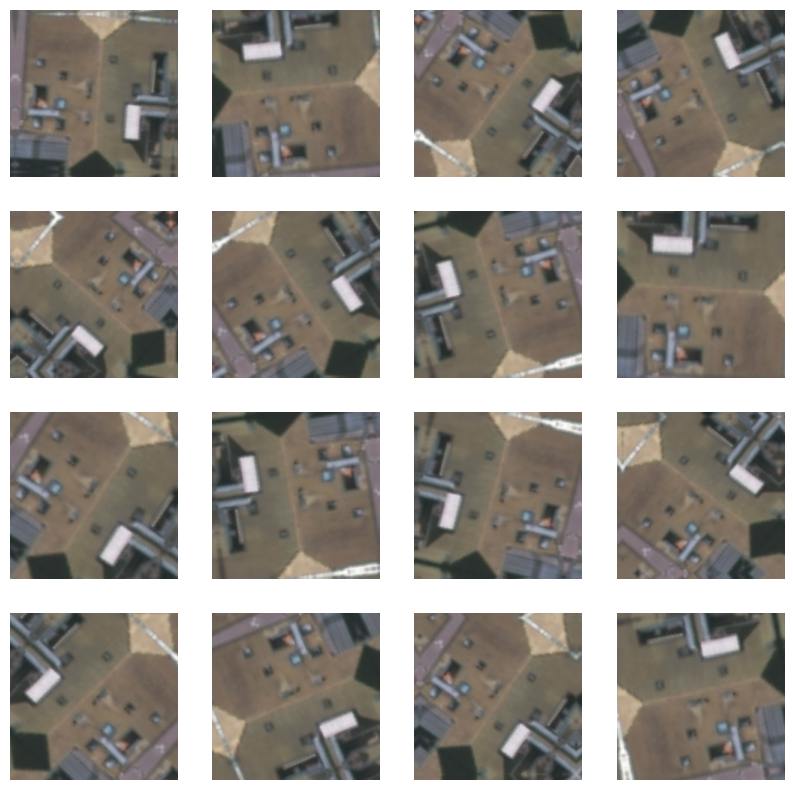

In [15]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(16):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

## Model evaluation
We will plot the training accuracy and the validation accuracy of the best model and the confusion matrix.

In [16]:
def plot_results(history):
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(1, len(accuracy) + 1)
    plt.plot(epochs, accuracy, "bo", label="Training accuracy")
    plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
    plt.title("Training and validation accuracy")
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, "bo", label="Training loss")
    plt.plot(epochs, val_loss, "b", label="Validation loss")
    plt.title("Training and validation loss")
    plt.legend()
    plt.show()

## CNN model
We implement a neural network model with several convolutional layers. We test the performance of the model using different values for the number of filters for each [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/) layer, and different optimizers. The search in the hyperparameters space is performed using [Keras Tuner](https://keras.io/keras_tuner/getting_started/).

In [11]:
image_height = 224
image_width = 224
image_channels = 3

In [17]:
def build_cnn_model(hp):
    inputs = keras.Input(shape=(image_height, image_width, image_channels))
    x = data_augmentation(inputs),
    x = layers.Rescaling(1./255)(inputs)

    x = layers.Conv2D(filters=hp.Int("filters", min_value=16, max_value=32, step=16),
                      kernel_size=3,
                      activation="relu",
                      name='1st_conv')(inputs)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=hp.Int("filters", min_value=32, max_value=64, step=16),
                      kernel_size=3,
                      activation="relu",
                      name='2nd_conv')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=hp.Int("filters", min_value=64, max_value=128, step=16),
                      kernel_size=3,
                      activation="relu",
                      name='3rd_conv')(x)
    x = layers.MaxPooling2D(pool_size=2)(x)

    x = layers.Conv2D(filters=hp.Int("filters", min_value=128, max_value=256, step=16),
                      kernel_size=3,
                      activation="relu",
                      name='4th_conv')(x)

    x = layers.Flatten()(x)
    x = layers.Dropout(0.5)(x)

    outputs = layers.Dense(3, activation="softmax")(x)
    model = keras.Model(inputs=inputs, outputs=outputs)

    #optimizer adam
    keras.optimizers.Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3]))
    #optimizer rmsprop =
    keras.optimizers.RMSprop(hp.Choice('learning_rate', values=[1e-2, 1e-3]))

    optimizers = hp.Choice(name="optimizer", values=["rmsprop", "adam"])

    model.compile(optimizer=optimizers, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

In [27]:
build_cnn_model(kt.HyperParameters()).summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1st_conv (Conv2D)                    │ (None, 222, 222, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 111, 111, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2nd_conv (Conv2D)                    │ (None, 109, 109, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 54, 54, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3rd_conv (Conv2D)                    │ (None, 52, 52, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 26, 26, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4th_conv (Conv2D)                    │ (None, 24, 24, 16)          │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │          27,651 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 35,059 (136.95 KB)

 Trainable params: 35,059 (136.95 KB)

 Non-trainable params: 0 (0.00 B)

### Kears tuner configuration

In [28]:
tuner = kt.BayesianOptimization(
    build_cnn_model,
    objective="val_accuracy",
    max_trials=20,
    executions_per_trial=2,
    directory="keras_tuner_test",
    overwrite=True,
)

In [29]:
tuner.search_space_summary()

Search space summary
Default search space size: 3
filters (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 32, 'step': 16, 'sampling': 'linear'}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001], 'ordered': True}
optimizer (Choice)
{'default': 'rmsprop', 'conditions': [], 'values': ['rmsprop', 'adam'], 'ordered': False}


In [30]:
callbacks = [keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)]

We start the search in the hyperparameters space

In [31]:
tuner.search(
    train_dataset,
    batch_size=32,
    epochs=50,
    validation_data = validation_dataset,
    callbacks=callbacks,
    verbose=2,
)

Trial 8 Complete [00h 02m 15s]
val_accuracy: 0.9919999837875366

Best val_accuracy So Far: 0.9963333308696747
Total elapsed time: 00h 23m 23s


In [42]:
tuner.results_summary()

Results summary
Results in keras_tuner_test/untitled_project
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
filters: 32
learning_rate: 0.001
optimizer: rmsprop
Score: 0.9963333308696747

Trial 03 summary
Hyperparameters:
filters: 32
learning_rate: 0.01
optimizer: rmsprop
Score: 0.9958333373069763

Trial 01 summary
Hyperparameters:
filters: 32
learning_rate: 0.001
optimizer: adam
Score: 0.995333343744278

Trial 05 summary
Hyperparameters:
filters: 16
learning_rate: 0.01
optimizer: rmsprop
Score: 0.9951666593551636

Trial 04 summary
Hyperparameters:
filters: 16
learning_rate: 0.01
optimizer: adam
Score: 0.9946666955947876

Trial 00 summary
Hyperparameters:
filters: 32
learning_rate: 0.01
optimizer: adam
Score: 0.9944999814033508

Trial 02 summary
Hyperparameters:
filters: 16
learning_rate: 0.001
optimizer: adam
Score: 0.9923333525657654

Trial 07 summary
Hyperparameters:
filters: 16
learning_rate: 0.001
optimizer: rmsprop
Score: 

In [32]:
top_n = 4
best_hps = tuner.get_best_hyperparameters(top_n)

In [33]:
for i in range(top_n):
    best_hp = best_hps[i]
    print(best_hp.values)

{'filters': 32, 'learning_rate': 0.001, 'optimizer': 'rmsprop'}
{'filters': 32, 'learning_rate': 0.01, 'optimizer': 'rmsprop'}
{'filters': 32, 'learning_rate': 0.001, 'optimizer': 'adam'}
{'filters': 16, 'learning_rate': 0.01, 'optimizer': 'rmsprop'}


We can retrain the model using the full training data (train and validation)

In [34]:
def get_best_epoch(hp):
    model = build_cnn_model(hp)

    callbacks=[
        keras.callbacks.EarlyStopping(
            monitor="val_loss", mode="min", patience=10)
    ]

    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=50,
        batch_size=32,
        callbacks=callbacks)

    val_loss_per_epoch = history.history["val_loss"]
    best_epoch = val_loss_per_epoch.index(min(val_loss_per_epoch)) + 1
    print(f"Best epoch: {best_epoch}")
    return best_epoch

In [45]:
def get_best_trained_model(hp):
    best_epoch = get_best_epoch(hp)
    model = build_cnn_model(hp)
    model.fit(
        train_dataset,
        batch_size=64,
        epochs=int(best_epoch * 1.2),
        validation_data = validation_dataset)
    return model

In [49]:
best_model = get_best_trained_model(best_hps[0])

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 8s 21ms/step - accuracy: 0.3915 - loss: 24.8516 - val_accuracy: 0.3643 - val_loss: 1.0906
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.3700 - loss: 1.1718 - val_accuracy: 0.3507 - val_loss: 3.1684
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.5531 - loss: 1.1276 - val_accuracy: 0.7790 - val_loss: 0.5477
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.7710 - loss: 0.5837 - val_accuracy: 0.8860 - val_loss: 0.3618
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8560 - loss: 0.3812 - val_accuracy: 0.9227 - val_loss: 0.1961
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.8947 - loss: 0.2972 - val_accuracy: 0.8563 - val_loss: 0.3643
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9262 - loss: 0.2298 - val_accuracy: 0.9653 - val_loss: 0.1065
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - accuracy: 0.9361 - loss: 0.2239 - val_acc

In [53]:
best_model_loss, best_model_acc = best_model.evaluate(test_dataset)
print(f"Test accuracy: {best_model_acc:.3f}")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9990 - loss: 0.0018
Test accuracy: 1.000


In [51]:
top_n_models = 1
best_model = tuner.get_best_models(top_n_models)

In [52]:
models = tuner.get_best_models(num_models=2)
best_model = models[0]
best_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 1st_conv (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 2nd_conv (Conv2D)                    │ (None, 109, 109, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 54, 54, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 3rd_conv (Conv2D)                    │ (None, 52, 52, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 26, 26, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ 4th_conv (Conv2D)                    │ (None, 24, 24, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 18432)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 3)                   │          55,299 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 83,939 (327.89 KB)

 Trainable params: 83,939 (327.89 KB)

 Non-trainable params: 0 (0.00 B)